In [ ]:
!pip install git+https://github.com/recohut/recohut.git@S346877

In [ ]:
# default_exp evaluation.sequences

# Sequence Evaluation
> Implementation of Sequential evaluation modules.

In [ ]:
#hide
from nbdev.showdoc import *
from fastcore.nb_imports import *
from fastcore.test import *

In [1]:
#export
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from recohut.evaluation.metrics import precision, recall, mrr

Dummy ItemPop model for examples

In [2]:
from recohut.utils.data import load_dataset
from recohut.utils.filters import filter_by_time, filter_top_k
from recohut.utils.splitting import split_last_session_out
from recohut.models.itempop import ItemPop_v2

df = load_dataset('music30_sample')
df.columns = ['session_id', 'user_id', 'item_id', 'ts', 'playtime']
df['ts'] = pd.to_datetime(df['ts'], unit='s')

# let's keep only the top-1k most popular items in the last month
df = filter_by_time(df, last_months=1, ts_col='ts')
df = filter_top_k(df, topk=1000, user_col='user_id', item_col='item_id', sess_col='session_id', ts_col='ts')

train, test = split_last_session_out(df, user_col='user_id', sess_col='session_id', seq_col='sequence', time_col='ts')

poprecommender = ItemPop_v2()
poprecommender.fit(train)

In [3]:
#exporti
def get_test_sequences(test_data, given_k, seq_col='sequence'):
  # we can run evaluation only over sequences longer than abs(LAST_K)
  test_sequences = test_data.loc[test_data[seq_col].map(len) > abs(given_k), seq_col].values
  return test_sequences

In [4]:
#exporti
def get_test_sequences_and_users(test_data, given_k, train_users, seq_col='sequence', user_col='user_id'):
    # we can run evaluation only over sequences longer than abs(LAST_K)
    mask = test_data[seq_col].map(len) > abs(given_k)
    mask &= test_data[user_col].isin(train_users)
    test_sequences = test_data.loc[mask, seq_col].values
    test_users = test_data.loc[mask, user_col].values
    return test_sequences, test_users

In [5]:
#exporti
def sequential_evaluation(recommender,
                          test_sequences,
                          evaluation_functions,
                          users=None,
                          given_k=1,
                          look_ahead=1,
                          top_n=10,
                          scroll=True,
                          step=1):
    """
    Runs sequential evaluation of a recommender over a set of test sequences
    :param recommender: the instance of the recommender to test
    :param test_sequences: the set of test sequences
    :param evaluation_functions: list of evaluation metric functions
    :param users: (optional) the list of user ids associated to each test sequence. Required by personalized models like FPMC.
    :param given_k: (optional) the initial size of each user profile, starting from the first interaction in the sequence.
                    If <0, start counting from the end of the sequence. It must be != 0.
    :param look_ahead: (optional) number of subsequent interactions in the sequence to be considered as ground truth.
                    It can be any positive number or 'all' to extend the ground truth until the end of the sequence.
    :param top_n: (optional) size of the recommendation list
    :param scroll: (optional) whether to scroll the ground truth until the end of the sequence.
                If True, expand the user profile and move the ground truth forward of `step` interactions. Recompute and evaluate recommendations every time.
                If False, evaluate recommendations once per sequence without expanding the user profile.
    :param step: (optional) number of interactions that will be added to the user profile at each step of the sequential evaluation.
    :return: the list of the average values for each evaluation metric
    """
    if given_k == 0:
        raise ValueError('given_k must be != 0')

    metrics = np.zeros(len(evaluation_functions))
    with tqdm(total=len(test_sequences)) as pbar:
        for i, test_seq in enumerate(test_sequences):
            if users is not None:
                user = users[i]
            else:
                user = None
            if scroll:
                metrics += sequence_sequential_evaluation(recommender,
                                                          test_seq,
                                                          evaluation_functions,
                                                          user,
                                                          given_k,
                                                          look_ahead,
                                                          top_n,
                                                          step)
            else:
                metrics += evaluate_sequence(recommender,
                                             test_seq,
                                             evaluation_functions,
                                             user,
                                             given_k,
                                             look_ahead,
                                             top_n)
            pbar.update(1)
    return metrics / len(test_sequences)

In [6]:
#exporti
def evaluate_sequence(recommender, seq, evaluation_functions, user, given_k, look_ahead, top_n):
    """
    :param recommender: which recommender to use
    :param seq: the user_profile/ context
    :param given_k: last element used as ground truth. NB if <0 it is interpreted as first elements to keep
    :param evaluation_functions: which function to use to evaluate the rec performance
    :param look_ahead: number of elements in ground truth to consider. if look_ahead = 'all' then all the ground_truth sequence is considered
    :return: performance of recommender
    """
    # safety checks
    if given_k < 0:
        given_k = len(seq) + given_k

    user_profile = seq[:given_k]
    ground_truth = seq[given_k:]

    # restrict ground truth to look_ahead
    ground_truth = ground_truth[:look_ahead] if look_ahead != 'all' else ground_truth
    ground_truth = list(map(lambda x: [x], ground_truth))  # list of list format

    if not user_profile or not ground_truth:
        # if any of the two missing all evaluation functions are 0
        return np.zeros(len(evaluation_functions))

    r = recommender.recommend(user_profile, user)[:top_n]

    if not r:
        # no recommendation found
        return np.zeros(len(evaluation_functions))
    reco_list = recommender.get_recommendation_list(r)

    tmp_results = []
    for f in evaluation_functions:
        tmp_results.append(f(ground_truth, reco_list))
    return np.array(tmp_results)

In [7]:
#exporti
def sequence_sequential_evaluation(recommender, seq, evaluation_functions, user, given_k, look_ahead, top_n, step):
    if given_k < 0:
        given_k = len(seq) + given_k

    eval_res = 0.0
    eval_cnt = 0
    for gk in range(given_k, len(seq), step):
        eval_res += evaluate_sequence(recommender, seq, evaluation_functions, user, gk, look_ahead, top_n)
        eval_cnt += 1
    return eval_res / eval_cnt

In [8]:
#export
def eval_seqreveal(train_data,
                   test_data,
                   model,
                   top_k=10,
                   ):
    """
    Evaluation with sequentially revealed user-profiles.

    Here we evaluate the quality of the recommendations in a setting in which 
    user profiles are revealed sequentially. The user profile starts from the 
    first GIVEN_K events (or, alternatively, from the last -GIVEN_K events if GIVEN_K<0).
    The recommendations are evaluated against the next LOOK_AHEAD events (the ground truth).
    The user profile is next expanded to the next STEP events, the ground truth is 
    scrolled forward accordingly, and the evaluation continues until the sequence ends.

    In typical next-item recommendation, we start with GIVEN_K=1, generate a set 
    of alternatives that will evaluated against the next event in the sequence 
    (LOOK_AHEAD=1), move forward of one step (STEP=1) and repeat until the 
    sequence ends.

    You can set the LOOK_AHEAD='all' to see what happens if you had to recommend 
    a whole sequence instead of a set of a set of alternatives to a user.

    Note:
        Metrics are averaged over each sequence first, then averaged over all test sequences.
    """
    GIVEN_K = 1
    LOOK_AHEAD = 1
    STEP = 1

    metrics=['precision', 'recall', 'mrr']

    test_sequences = get_test_sequences(test_data, GIVEN_K)
    print('{} sequences available for evaluation'.format(len(test_sequences)))
    results = sequential_evaluation(model,
                                    test_sequences=test_sequences,
                                    given_k=GIVEN_K,
                                    look_ahead=LOOK_AHEAD,
                                    evaluation_functions=[eval(metric) for metric in metrics],
                                    top_n=top_k,
                                    scroll=True,  # scrolling averages metrics over all profile lengths
                                    step=STEP)
    
    results = [results, GIVEN_K, LOOK_AHEAD, STEP]
    results = {
        "Model": type(model).__name__,
        "GIVEN_K": results[1],
        "LOOK_AHEAD": results[2],
        "STEP": results[3],
        f"Precision@{top_k}": results[0][0],
        f"Recall@{top_k}": results[0][1],
        f"MRR@{top_k}": results[0][2],
        }
    return results

In [ ]:
results = eval_seqreveal(train, test, poprecommender)
results

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:00<00:00, 7692.78it/s]


{'GIVEN_K': 1,
 'LOOK_AHEAD': 1,
 'MRR@10': 0.01107661288687696,
 'Model': 'ItemPop_v2',
 'Precision@10': 0.002954052226797915,
 'Recall@10': 0.029540522267979246,
 'STEP': 1}

In [10]:
#export
def eval_staticprofile(train_data,
                       test_data,
                       model,
                       top_k=10,
                       ):
    """
    Evaluation with "static" user-profiles.

    Here we evaluate the quality of the recommendations in a setting in which 
    user profiles are instead static. The user profile starts from the first 
    GIVEN_K events (or, alternatively, from the last -GIVEN_K events if GIVEN_K<0).
    The recommendations are evaluated against the next LOOK_AHEAD events (the ground truth).
    The user profile is not extended and the ground truth doesn't move forward. 
    This allows to obtain "snapshots" of the recommendation performance for 
    different user profile and ground truth lenghts. Also here you can set the 
    LOOK_AHEAD='all' to see what happens if you had to recommend a whole sequence 
    instead of a set of a set of alternatives to a user.
    """
    GIVEN_K = 1
    LOOK_AHEAD = 'all'
    STEP=1

    metrics=['precision', 'recall', 'mrr']

    test_sequences = get_test_sequences(test_data, GIVEN_K)
    print('{} sequences available for evaluation'.format(len(test_sequences)))
    results = sequential_evaluation(model,
                                            test_sequences=test_sequences,
                                            given_k=GIVEN_K,
                                            look_ahead=LOOK_AHEAD,
                                            evaluation_functions=[eval(metric) for metric in metrics],
                                            top_n=top_k,
                                            scroll=False  # notice that scrolling is disabled!
                                    )
        
    results = [results, GIVEN_K, LOOK_AHEAD, STEP]
    results = {
        "Model": type(model).__name__,
        "GIVEN_K": results[1],
        "LOOK_AHEAD": results[2],
        "STEP": results[3],
        f"Precision@{top_k}": results[0][0],
        f"Recall@{top_k}": results[0][1],
        f"MRR@{top_k}": results[0][2],
        }
    return results

In [11]:
results = eval_staticprofile(train, test, poprecommender)
results

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:00<00:00, 25580.85it/s]


{'GIVEN_K': 1,
 'LOOK_AHEAD': 'all',
 'MRR@10': 0.04329665683868385,
 'Model': 'ItemPop_v2',
 'Precision@10': 0.014389484607402345,
 'Recall@10': 0.02903793265734238,
 'STEP': 1}

In [12]:
#export
def eval_reclength(train_data,
                   test_data,
                   model,
                   ):
    """
    Evaluation for different recommendation list lengths. Analysis of next-item recommendation. 
    In next-item recommendation, we analyse the performance of the recommender system in the 
    scenario of next-item recommendation over the following dimensions:
    - the length of the recommendation list, and
    - the length of the user profile.

    Note: 
        This evaluation is by no means exhaustive, as different the hyper-parameters 
        of the recommendation algorithm should be carefully tuned before drawing any 
        conclusions. Unfortunately, given the time constraints for this tutorial, we 
        had to leave hyper-parameter tuning out. A very useful reference about careful 
        evaluation of (session-based) recommenders can be found at:
    """
    GIVEN_K = 1
    LOOK_AHEAD = 1
    STEP = 1
    topk_list = [1, 5, 10, 20, 50, 100]
    res_list = []

    metrics=['precision', 'recall', 'mrr']

    test_sequences = get_test_sequences(test_data, GIVEN_K)
    print('{} sequences available for evaluation'.format(len(test_sequences)))
    for topn in topk_list:
        print('Evaluating recommendation lists with length: {}'.format(topn))      
        res_tmp = sequential_evaluation(model,
                                        test_sequences=test_sequences,
                                        given_k=GIVEN_K,
                                        look_ahead=LOOK_AHEAD,
                                        evaluation_functions=[eval(metric) for metric in metrics],
                                        top_n=topn,
                                        scroll=True,  # here we average over all profile lengths
                                        step=STEP)
        mvalues = list(zip(metrics, res_tmp))
        res_list.append((topn, mvalues))

    # show separate plots per metric
    # fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(15,5))
    res_list_t = list(zip(*res_list))
    results = []
    for midx, metric in enumerate(metrics):
        mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
        fig, ax = plt.subplots(figsize=(5,5))
        ax.plot(topk_list, mvalues)
        ax.set_title(metric)
        ax.set_xticks(topk_list)
        ax.set_xlabel('List length')
        fig.tight_layout()
        results.append(fig)
        plt.close()

    return results

In [13]:
results = eval_reclength(train, test, poprecommender)
results

2891 sequences available for evaluation
Evaluating recommendation lists with length: 1


100%|██████████| 2891/2891 [00:00<00:00, 13501.10it/s]


Evaluating recommendation lists with length: 5


100%|██████████| 2891/2891 [00:00<00:00, 10429.57it/s]


Evaluating recommendation lists with length: 10


100%|██████████| 2891/2891 [00:00<00:00, 7581.17it/s]


Evaluating recommendation lists with length: 20


100%|██████████| 2891/2891 [00:00<00:00, 5239.62it/s]


Evaluating recommendation lists with length: 50


100%|██████████| 2891/2891 [00:01<00:00, 2856.52it/s]


Evaluating recommendation lists with length: 100


100%|██████████| 2891/2891 [00:01<00:00, 1588.25it/s]


[<Figure size 360x360 with 1 Axes>,
 <Figure size 360x360 with 1 Axes>,
 <Figure size 360x360 with 1 Axes>]

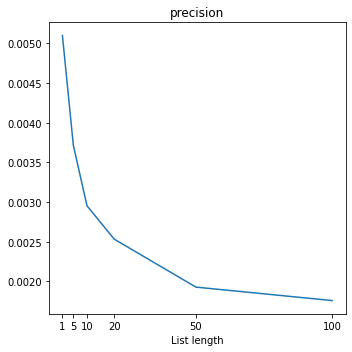

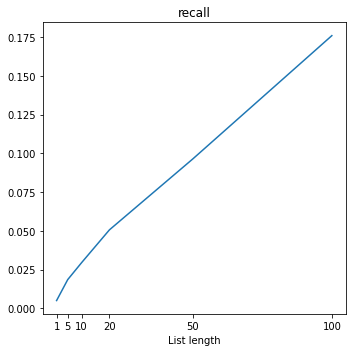

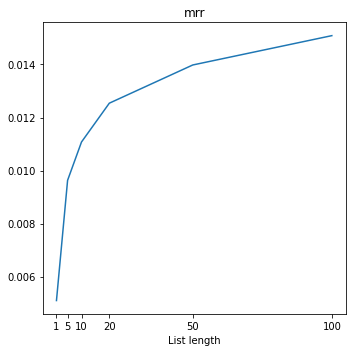

In [14]:
display(results[0])
display(results[1])
display(results[2])

In [15]:
#export
def eval_profilelength(train_data,
                       test_data,
                       model,
                       top_k=20,
                       ):
    """
    Evaluation for different user profile lengths. Analysis of next-item recommendation. 
    In next-item recommendation, we analyse the performance of the recommender system in the 
    scenario of next-item recommendation over the following dimensions:
    - the length of the recommendation list, and
    - the length of the user profile.

    Note: 
        This evaluation is by no means exhaustive, as different the hyper-parameters 
        of the recommendation algorithm should be carefully tuned before drawing any 
        conclusions. Unfortunately, given the time constraints for this tutorial, we 
        had to leave hyper-parameter tuning out. A very useful reference about careful 
        evaluation of (session-based) recommenders can be found at:
    """
    given_k_list = [1, 2, 3, 4]
    LOOK_AHEAD = 1
    STEP = 1
    topk_list = [1, 5, 10, 20, 50, 100]
    res_list = []

    metrics=['precision', 'recall', 'mrr']

    test_sequences = get_test_sequences(test_data, max(given_k_list))
    print('{} sequences available for evaluation'.format(len(test_sequences)))
    for gk in given_k_list:
        print('Evaluating profiles having length: {}'.format(gk))   
        res_tmp = sequential_evaluation(model,
                                        test_sequences=test_sequences,
                                        given_k=gk,
                                        look_ahead=LOOK_AHEAD,
                                        evaluation_functions=[eval(metric) for metric in metrics],
                                        top_n=top_k,
                                        scroll=False,  # here we stop at each profile length
                                        step=STEP)
        mvalues = list(zip(metrics, res_tmp))
        res_list.append((gk, mvalues))

    # show separate plots per metric
    # fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(15,5))
    res_list_t = list(zip(*res_list))
    results = []
    for midx, metric in enumerate(metrics):
        mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
        fig, ax = plt.subplots(figsize=(5,5))
        ax.plot(given_k_list, mvalues)
        ax.set_title(metric)
        ax.set_xticks(given_k_list)
        ax.set_xlabel('Profile length')
        fig.tight_layout()
        results.append(fig)
        plt.close()
        
    return results

In [16]:
results = eval_profilelength(train, test, poprecommender)
results

1164 sequences available for evaluation
Evaluating profiles having length: 1


100%|██████████| 1164/1164 [00:00<00:00, 22645.31it/s]


Evaluating profiles having length: 2


100%|██████████| 1164/1164 [00:00<00:00, 23195.63it/s]


Evaluating profiles having length: 3


100%|██████████| 1164/1164 [00:00<00:00, 22383.26it/s]


Evaluating profiles having length: 4


100%|██████████| 1164/1164 [00:00<00:00, 18985.69it/s]


[<Figure size 360x360 with 1 Axes>,
 <Figure size 360x360 with 1 Axes>,
 <Figure size 360x360 with 1 Axes>]

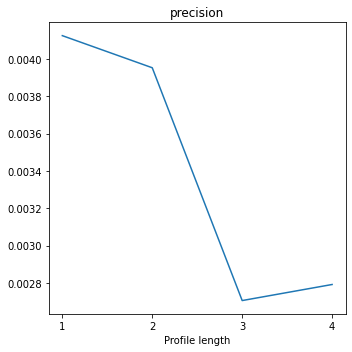

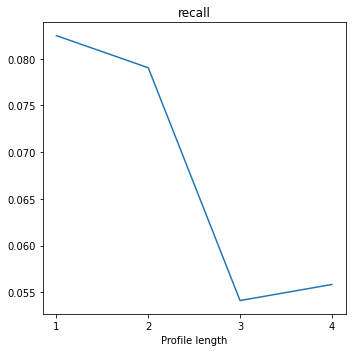

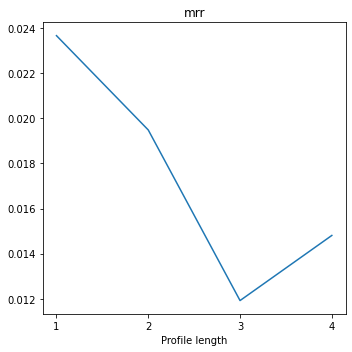

In [17]:
display(results[0])
display(results[1])
display(results[2])

In [ ]:
#hide
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p recohut

numpy     1.19.5
pandas    1.1.5
PIL.Image 7.1.2
IPyPlot   1.1.0
Sparsh A. 
last updated: 2022-01-29 13:28:01 

recohut 0.0.12

compiler   : GCC 7.5.0
system     : Linux
release    : 5.4.144+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
